In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Tourism_processed.csv')

In [3]:
df = df.drop('Name of the Monument',axis=1)


In [4]:
df.head()

,Circle,Domestic - 2016-17,Foreign - 2016-17,Domestic - 2017-18,Foreign - 2017-18,Domestic Percentage growth - 2017-18/2016-17,Foreign Percentage growth - 2017-18/2016-17,Airport(in km),Railway(in km)
0,Agra,5419608,668403,5663136,794556,4.5,18.9,12.0,6.9
1,Agra,1799953,441326,2008208,489822,11.6,11.0,11.0,5.0
2,Agra,418502,22389,362070,23638,-13.5,5.6,13.0,12.0
3,Agra,427854,126114,962069,301181,124.9,138.8,35.0,37.0
4,Agra,108392,129177,138524,76572,27.8,-40.7,15.0,9.0


In [6]:
num_data = df.select_dtypes(exclude='object').columns.tolist()
cat_data = df.select_dtypes(include='object').columns.tolist()

print(num_data)
print(cat_data)


['Domestic - 2016-17', 'Foreign - 2016-17', 'Domestic - 2017-18', 'Foreign - 2017-18', 'Domestic Percentage growth - 2017-18/2016-17', 'Foreign Percentage growth - 2017-18/2016-17', 'Airport(in km)', 'Railway(in km)']
['Circle']


In [7]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer,RobustScaler

pt=PowerTransformer()
#features = ["Domestic - 2016-17", "Foreign - 2016-17","Domestic - 2017-18", "Foreign - 2017-18"]

features = ["Domestic - 2016-17", "Foreign - 2016-17"]

X_subset = df[features] 
scaler = PowerTransformer().fit(X_subset)
X = scaler.transform(X_subset)
pd.DataFrame(X, columns=X_subset.columns).describe()




,count,mean,std,min,25%,50%,75%,max
Domestic - 2016-17,113.0,-4.087193e-16,1.004454,-2.670759,-0.690548,0.049738,0.603918,2.785335
Foreign - 2016-17,113.0,1.974821e-16,1.004454,-2.781733,-0.723607,-0.035637,0.739043,2.310067


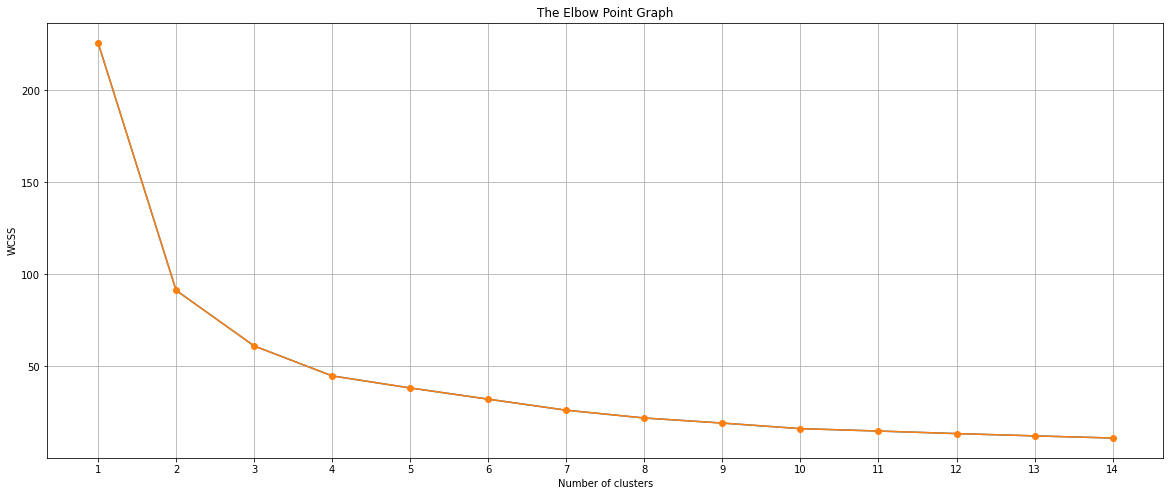

In [8]:
from sklearn.cluster import KMeans
wcss = []  # Within-Cluster-Sum-of-Squares
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 8))
plt.plot(range(1, 15), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.plot(range(1, 15), wcss, "-o")
plt.xticks(range(1, 15))
plt.grid(True)
plt.show()


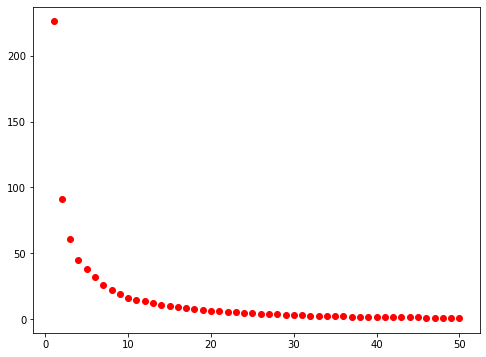

The best K sugest:  10


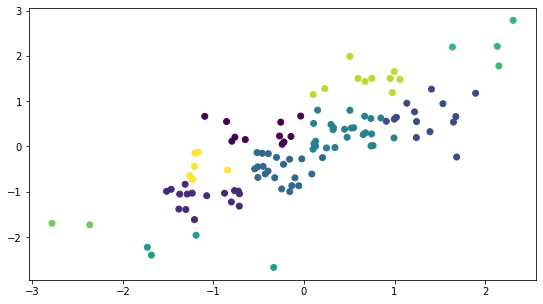

In [9]:
from sklearn.cluster import KMeans
wcss = [] 
cl=50
corte = 0.1
anterior = 100000000000000
cost = []
K_best = cl

for k in range(1,cl+1):
    model = KMeans(n_clusters=k, init='k-means++',n_init=10,max_iter=300,tol=1e-04,random_state=10)
    model=model.fit(X)
    labels=model.labels_
    interia=model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte):
        K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range(1, cl+1), cost, c='red')
plt.show()

print('The best K sugest: ', K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,
               max_iter=300, tol=1e-04, random_state=101)

model = model.fit(X)
labels = model.labels_

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(121)
plt.scatter(x=X[:, 1], y=X[:, 0], c=model.labels_.astype(float))

# ax = fig.add_subplot(132)
# plt.scatter(x=X[:, 2], y=X[:, 0], c=model.labels_.astype(float))

# ax = fig.add_subplot(133)
# plt.scatter(x=X[:, 3], y=X[:, 0], c=model.labels_.astype(float))



K equal to 3 -> observed low rates of gain in the decay of the distortions with the decrease of K reaching the limit of 10 % with the K equal to 9.



Silhouette analysis on K-Means clustering

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


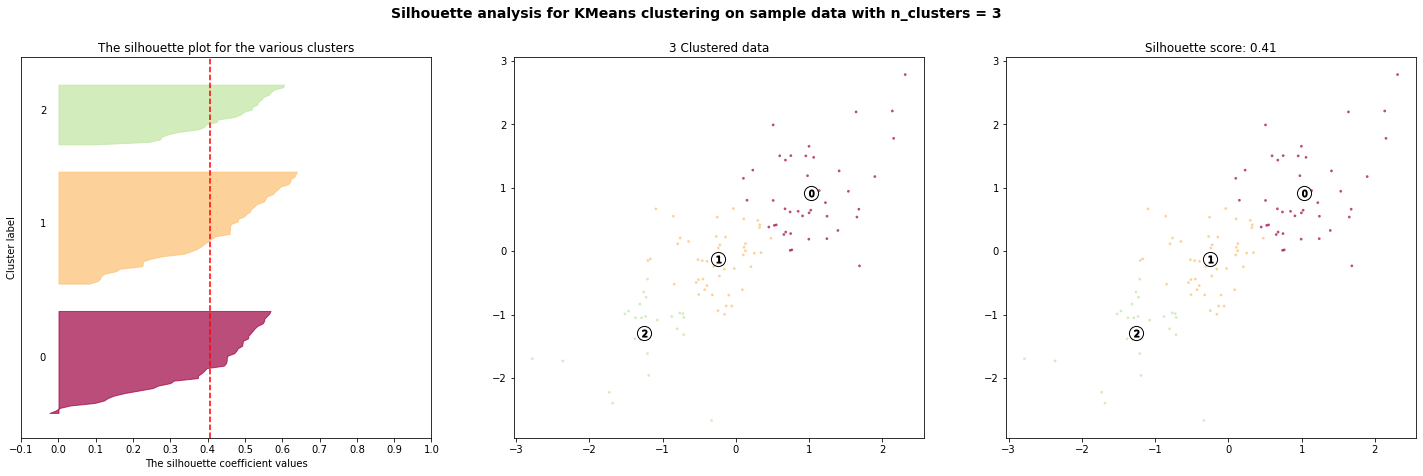

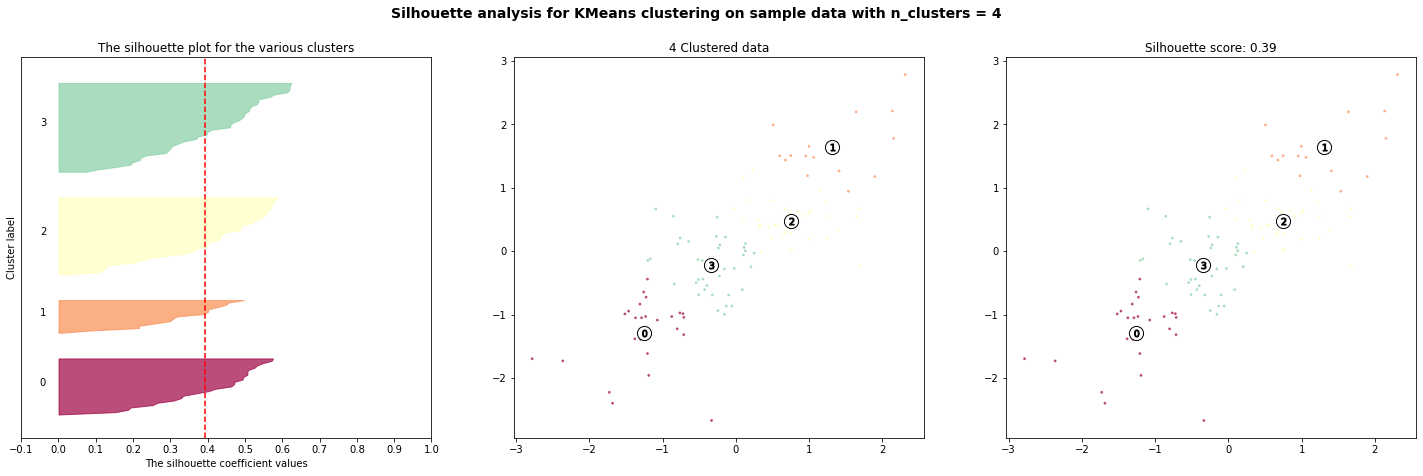

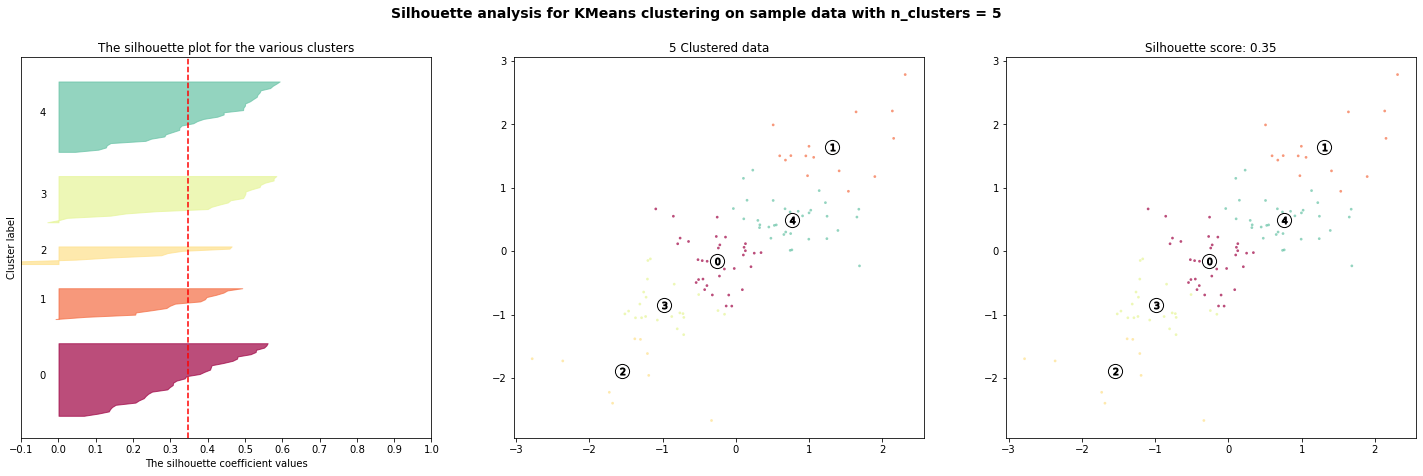

In [11]:
cluster_centers = dict()
K_best=6
for n_clusters in range(3,K_best):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X = X, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X[:, x], X[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    

    x = 1
    ax3.scatter(X[:, x], X[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

1. Check for homogenity. Find average distance in cluster 2 and 1. and compare it


All clusters valid
3,5 have wide fluctuations

In [12]:

for i in range(3, K_best+1, 2):
    print("for {} clusters the silhouette score is {:1.3f}".format(
        i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(
        cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(cent_transformed, columns=features))
    print('-'*50)


for 3 clusters the silhouette score is 0.406
Centers of each cluster:
   Domestic - 2016-17  Foreign - 2016-17
0       606011.070943       22718.648843
1       128432.690609         781.951340
2        14306.657923          53.854085
--------------------------------------------------
for 5 clusters the silhouette score is 0.346
Centers of each cluster:
   Domestic - 2016-17  Foreign - 2016-17
0        1.234924e+05         758.556582
1        1.528207e+06       47461.177409
2        3.470423e+03          24.425511
3        3.545935e+04         112.445843
4        3.384462e+05       11198.885997
--------------------------------------------------


,Circle,Domestic - 2016-17,Foreign - 2016-17,Domestic - 2017-18,Foreign - 2017-18,Domestic Percentage growth - 2017-18/2016-17,Foreign Percentage growth - 2017-18/2016-17,Airport(in km),Railway(in km),clusters_3,clusters_4,clusters_5
0,Agra,5419608,668403,5663136,794556,4.5,18.9,12.0,6.9,0,1,1
1,Agra,1799953,441326,2008208,489822,11.6,11.0,11.0,5.0,0,1,1
2,Agra,418502,22389,362070,23638,-13.5,5.6,13.0,12.0,0,2,4
3,Agra,427854,126114,962069,301181,124.9,138.8,35.0,37.0,0,2,4
4,Agra,108392,129177,138524,76572,27.8,-40.7,15.0,9.0,0,2,4


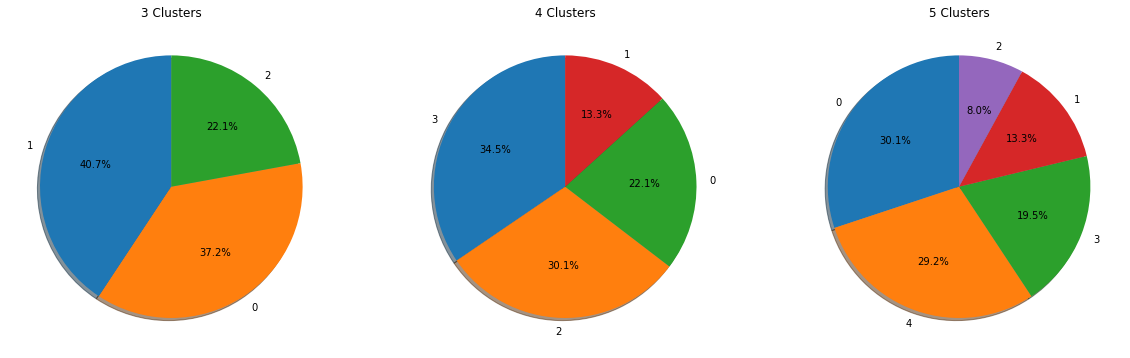

In [13]:
df['clusters_3'] = cluster_centers[3]['labels']
df['clusters_4'] = cluster_centers[4]['labels']

df['clusters_5'] = cluster_centers[5]['labels']
display(df.head())

fig = plt.figure(figsize=(20, 7))
f1 = fig.add_subplot(131)
market = df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index,
            autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')


f1 = fig.add_subplot(132)
market = df.clusters_4.value_counts()
g = plt.pie(market, labels=market.index,
            autopct='%1.1f%%', shadow=True, startangle=90)        
plt.title('4 Clusters')


f1 = fig.add_subplot(133)
market = df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index,
            autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
plt.show()


In [14]:
# df['clusters_3'] = cluster_centers[3]['labels']
# df['clusters_4'] = cluster_centers[4]['labels']

# df['clusters_5'] = cluster_centers[5]['labels']
# df['clusters_7'] = cluster_centers[7]['labels']
# df['clusters_9'] = cluster_centers[9]['labels']

# display(df.head())

# fig = plt.figure(figsize=(20, 7))
# f1 = fig.add_subplot(141)
# market = df.clusters_3.value_counts()
# g = plt.pie(market, labels=market.index,
#             autopct='%1.1f%%', shadow=True, startangle=90)
# plt.title('3 Clusters')




# f1 = fig.add_subplot(142)
# market = df.clusters_5.value_counts()
# g = plt.pie(market, labels=market.index,
#             autopct='%1.1f%%', shadow=True, startangle=90)        
# plt.title('5 Clusters')


# f1 = fig.add_subplot(143)
# market = df.clusters_7.value_counts()
# g = plt.pie(market, labels=market.index,
#             autopct='%1.1f%%', shadow=True, startangle=90)
# plt.title('7 Clusters')
# plt.show()

# f1 = fig.add_subplot(144)
# market = df.clusters_9.value_counts()
# g = plt.pie(market, labels=market.index,
#             autopct='%1.1f%%', shadow=True, startangle=90)
# plt.title('9 Clusters')
# plt.show()


Text(0.5, 1.0, '4 Clusters')

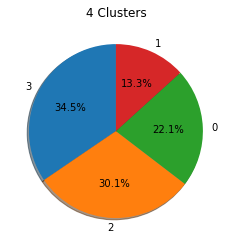

In [15]:

market = df.clusters_4.value_counts()
g = plt.pie(market, labels=market.index,
            autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('4 Clusters')


In [16]:
clusterer = KMeans(n_clusters=4,init='k-means++',random_state=10).fit(X)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(X)
print(centers)


[[-1.29766174 -1.26114961]
 [ 1.64177388  1.30619683]
 [ 0.48294131  0.74584521]
 [-0.2206428  -0.34417819]]


In [17]:
print(c_preds[0:100])


[1 1 2 2 2 2 3 0 1 1 2 2 3 3 1 2 2 2 2 2 2 2 3 3 0 1 2 3 3 0 3 0 1 3 3 0 0
 0 0 1 1 1 1 2 3 3 3 0 0 2 2 2 2 3 0 3 3 3 0 0 2 0 1 1 0 3 3 0 3 3 3 2 2 2
 3 3 2 3 2 0 3 1 2 3 2 3 3 2 3 0 0 2 3 2 3 3 0 3 3 1]


['blue', 'blue', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'blue']


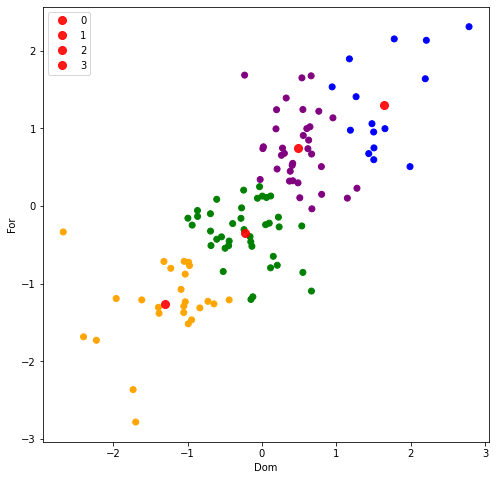

In [18]:
import matplotlib
fig = plt.figure(figsize=(8, 8))
colors = ['orange', 'blue', 'purple', 'green']
colored = [colors[k] for k in c_preds]
print(colored[0:10])
plt.scatter(X[:, 0], X[:, 1], color=colored)
for ci, c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8,
             color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('Domestic')
plt.ylabel('Foreign')
plt.legend()
plt.show()


In [19]:
len(df['Circle'].unique())

24

In [20]:
df.Circle.value_counts()[0:10]


Mumbai         10
Delhi          10
Agra            8
Hyderabad       8
Bhopal          7
Chennai         7
Dharwad         6
Aurangabad      6
Patna           5
Lucknow         5
Name: Circle, dtype: int64

In [21]:

data=pd.DataFrame()

data['Circle']=df.Circle.copy()
data=pd.get_dummies(data,columns=['Circle'])


In [22]:
#data['Circle'] = df.Circle.copy()
data.insert(0,'Circle',df['Circle'])

In [23]:
data

,Circle,Circle_Agra,Circle_Aurangabad,Circle_Bengaluru,Circle_Bhopal,Circle_Bhubaneswar,Circle_Chandigarh,Circle_Chennai,Circle_Delhi,Circle_Dharwad,...,Circle_Kolkata,Circle_Lucknow,Circle_Mumbai,Circle_Patna,Circle_Raipur,Circle_Sarnath,Circle_Shimla Mini,Circle_Srinagar,Circle_Thrissur,Circle_Vadodara
0,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,Vadodara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
109,Vadodara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
110,Vadodara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
111,Vadodara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
# cust_prod = pd.DataFrame(df.Circle)
# # cust_prod = pd.crosstab(df.Circle3)
# # cust_prod.head(10)



In [25]:
clust_prod = data.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)


,Circle,Circle_Agra,Circle_Aurangabad,Circle_Bengaluru,Circle_Bhopal,Circle_Bhubaneswar,Circle_Chandigarh,Circle_Chennai,Circle_Delhi,Circle_Dharwad,...,Circle_Lucknow,Circle_Mumbai,Circle_Patna,Circle_Raipur,Circle_Sarnath,Circle_Shimla Mini,Circle_Srinagar,Circle_Thrissur,Circle_Vadodara,cluster
0,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
5,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
6,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
7,Agra,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Aurangabad,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,Aurangabad,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
# print(clust_prod.shape)
# f, arr = plt.subplots(2, 2, sharex=True, figsize=(15, 15))

# c1_count = len(clust_prod[clust_prod['cluster'] == 0])

# c1 = clust_prod[clust_prod['cluster'] == 1].drop('cluster', axis=1).mean()
# arr[0, 1].bar(range(len(clust_prod.drop('cluster', axis=1).columns)), c1)

# c2 = clust_prod[clust_prod['cluster'] == 2].drop('cluster', axis=1).mean()
# arr[1, 0].bar(range(len(clust_prod.drop('cluster', axis=1).columns)), c2)

# c3 = clust_prod[clust_prod['cluster'] == 3].drop('cluster', axis=1).mean()
# arr[1, 1].bar(range(len(clust_prod.drop('cluster', axis=1).columns)), c3)

# # c4 = clust_prod[clust_prod['cluster'] == 4].drop('cluster', axis=1).mean()
# # arr[1, 1].bar(range(len(clust_prod.drop('cluster', axis=1).columns)), c4)
# plt.show()


In [27]:
c0 = clust_prod[clust_prod['cluster'] == 0].drop('cluster', axis=1).mean()
c0.sort_values(ascending=False)[0:10]


Circle_Chennai       0.16
Circle_Srinagar      0.12
Circle_Hyderabad     0.08
Circle_Mumbai        0.08
Circle_Delhi         0.08
Circle_Guwahati      0.08
Circle_Agra          0.04
Circle_Sarnath       0.04
Circle_Raipur        0.04
Circle_Lucknow       0.04
dtype: float64

In [28]:
c1 = clust_prod[clust_prod['cluster'] == 1].drop('cluster', axis=1).mean()
c1.sort_values(ascending=False)[0:10]


Circle_Delhi           0.266667
Circle_Agra            0.133333
Circle_Hyderabad       0.133333
Circle_Aurangabad      0.133333
Circle_Bengaluru       0.066667
Circle_Bhubaneswar     0.066667
Circle_Chennai         0.066667
Circle_Sarnath         0.066667
Circle_Mumbai          0.066667
Circle_Lucknow         0.000000
dtype: float64

In [29]:
c2 = clust_prod[clust_prod['cluster'] == 2].drop('cluster', axis=1).mean()
c2.sort_values(ascending=False)[0:10]

Circle_Agra           0.117647
Circle_Bhopal         0.117647
Circle_Dharwad        0.117647
Circle_Bengaluru      0.088235
Circle_Mumbai         0.088235
Circle_Aurangabad     0.058824
Circle_Patna          0.058824
Circle_Lucknow        0.058824
Circle_Jodhpur        0.058824
Circle_Vadodara       0.058824
dtype: float64

In [30]:
c3 = clust_prod[clust_prod['cluster'] == 3].drop('cluster', axis=1).mean()
c3.sort_values(ascending=False)[0:10]

Circle_Hyderabad       0.102564
Circle_Mumbai          0.102564
Circle_Delhi           0.076923
Circle_Guwahati        0.076923
Circle_Patna           0.076923
Circle_Vadodara        0.051282
Circle_Lucknow         0.051282
Circle_Bhopal          0.051282
Circle_Bhubaneswar     0.051282
Circle_Chennai         0.051282
dtype: float64

## Checking our knock out criteria for Cluster 1 and 2

### Is HOMOGENOUS???

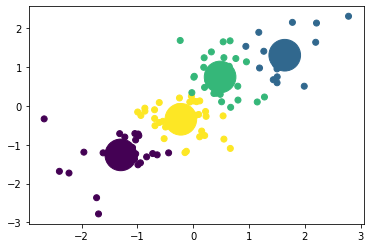

In [34]:
centroids=clusterer.cluster_centers_
plt.scatter(X[:,0], X[:,1], c=c_preds)
plt.scatter(centroids[:, 0], centroids[:, 1],
            c=range(centroids.shape[0]), s=1000)


In [39]:
from scipy.spatial import distance_matrix

dist_mat = pd.DataFrame(distance_matrix(X, centroids))

dist_mat.groupby(c_preds).mean()



,0,1,2,3
0,0.623921,3.929450,2.722493,1.480919
1,3.926155,0.685126,1.379792,2.525648
2,2.715981,1.374407,0.490612,1.357999
3,1.481116,2.524478,1.363246,0.496892


The columns denote the centroid number and rows denote the mean distance of the points in a cluster.

In [ ]:
#dist_mat.idxmin(axis=1) == c_preds

# from scipy.spatial.distance import cdist
# dm = cdist(df, centroids)
